**Indiquer dans la boîte ci-dessous vos noms et prénoms**

Ahmed SAOUDAT

# 3I026 - Intelligence artificielle & Data science

## TP 2 - k-plus proches voisins (*k-NN*)

Dans ce TP, nous allons principalement mettre en place une "architecture" de code nous permettant petit à petit de tester différents modèles d'apprentissage supervisé et programmer les k-NN. Nous allons nous restreindre au cas binaire où les données sont étiquetées $+1$ ou $-1$.

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

**Remarque** La concaténation de vecteurs s'obtient à l'aide de la fonction `vstack` de numpy.

### Étape 1: dataset

La première étape consiste à définir une classe permettant de stocker les données d'apprentissage, de validation et de test. Nous considérerons que les données tiennent en mémoire. Nous allons définir une classe permettant de stocker des couples $\{(x_1,y_1),...,(x_n,y_n)\}$. Les $x_i$ et $y_i$ seront des tableaux numpy.

In [2]:
class LabeledSet:  
    
    def __init__(self, input_dimension):
        self.input_dimension = input_dimension
        self.nb_examples = 0
    
    def addExample(self,vector,label):
        if (self.nb_examples == 0):
            self.x = np.array([vector])
            self.y = np.array([label])
        else:
            self.x = np.vstack((self.x, vector))
            self.y = np.vstack((self.y, label))
        
        self.nb_examples = self.nb_examples + 1
    
    #Renvoie la dimension de l'espace d'entrée
    def getInputDimension(self):
        return self.input_dimension
    
    #Renvoie le nombre d'exemples dans le set
    def size(self):
        return self.nb_examples
    
    #Renvoie la valeur de x_i
    def getX(self, i):
        return self.x[i]
        
    
    #Renvoie la valeur de y_i
    def getY(self, i):
        return(self.y[i])

#### Génération de données ''Jouet''

Nous allons pour l'instant nous intéresser à des datasets "jouet" générés selon des distributions choisies à la main. Commençons par un dataset en 2 dimensions (entrée) et 1 dimension (sortie): $x_i \in \mathbb{R}^2$, $y_i \in \{-1;+1\}$ tel que les données sont générées selon deux gaussiennes. Pour cela, nous utiliserons la fonction `numpy.random.multivariate_normal` - http://docs.scipy.org/doc/numpy/reference/generated/numpy.random.multivariate_normal.html

- `positive_center` est le centre de la gaussienne des points positifs (vecteur de taille 2)
- `positive_sigma` est la variance de la gaussienne (sous forme de matrice 2*2)
- Idem pour `negative`

Générer une premiere gaussienne associée au label $+1$.

Y ajouter une seconde gaussienne associée au label $-1$.

15


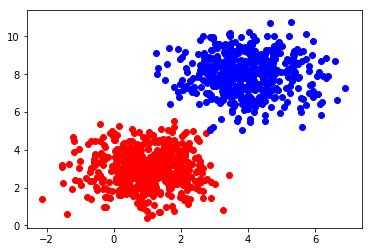

In [3]:
"""
le dataset est en 2D: une entrée et une sortie

"""
my_set = LabeledSet(15)
print my_set.getInputDimension()

#i1 = np.random.normal(size = 100)
mean = [1, 2]
cov = [[1, 2], [0, 1]]
data1 = np.random.multivariate_normal([1, 3], [[1, 0], [0, 1]], size = 500)# 1ere gaussienne
data2 = np.random.multivariate_normal([4, 8], [[1, 0], [0, 1]], size = 500)#2eme gaussienne

plt.scatter(data1[:, 0], data1[:, 1], color='r')
plt.scatter(data2[:, 0], data2[: ,1], color='b')


Le data set peut être affiché en utilisant matplotlib (pour vérifier) et plus précisément la fonction `matplotlib.pyplot.scatter` permettant de dessiner un nuage de points - http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter -

In [4]:
import matplotlib.pyplot as plt
# Permet d'afficher les figures directement dans le notebook:
%matplotlib inline

def plot2DSet(dataset):
    plt.scatter(dataset.x[0:int(dataset.size()/2),0],dataset.x[0:int(dataset.size()/2),1],marker='o')
    plt.scatter(dataset.x[int(dataset.size()/2):dataset.size(),0],dataset.x[int(dataset.size()/2):dataset.size(),1],marker='x')

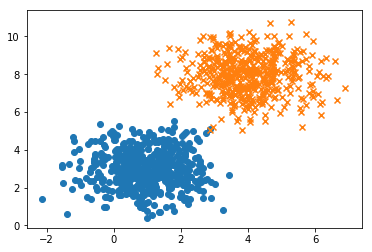

In [5]:
#dans ce cas on travaille dans le plan donc 2D
the_set = LabeledSet(2)

#ajout données labelisées +1
for d in data1:
    the_set.addExample(d, +1)
#ajout données labelisées -1
for d in data2:
    the_set.addExample(d, -1)
    
plot2DSet(the_set)

### Étape 2: les classifieurs

Un classifieur (binaire) permet, pour chaque point d'entrée, de calculer un score. Si le score est négatif, la donnée est associée à la classe $-1$, sinon à la classe $+1$. Commençons par définir une classe permettant par la suite de définir plusieurs classifieurs.

Pour l'instant les méthodes `train` et `predict` ne seront pas définies car elles dépendent du modèle.

La fonction `computeAccuracy` renvoie le pourcentage de points bien classés. Elle peut être définie dès maintenant.



In [6]:
class Classifier:
    def __init__(self, input_dimension):
        self.input_dimension = input_dimension
    
    
    #Permet de calculer la prediction sur x => renvoie un score
    def predict(self, x):
        raise NotImplementedError("Please Implement this method")

    
    #Permet d'entrainer le modele sur un ensemble de données
    def train(self, labeledSet):
        raise NotImplementedError("Please Implement this method")
    
    #Permet de calculer la qualité du système 
    def accuracy(self, dataset):
        #pour chaque x, y dans dataset comparer predict(x) et y
        #predict depend du modèle 
        cpt = 0;
        for i in range(dataset.size()):
            if predict(dataset.getX(i)) == dataset.getY(i):
                cpt+=1
        return float(cpt) / dataset.size()

Nous allons maintenant définir un classifieur linéaire aléatoire :
- la fonction `predict` renvoie la valeur de $\langle x | w\rangle$ où $w$ est un vecteur (de taille `input_dimension`) tiré aléatoirement à la construction du classifieur.


In [7]:
class ClassifierRandom(Classifier):
    def __init__(self, input_dimension):
        self.input_dimension = input_dimension
        self.w = np.random.randn(self.input_dimension)*2
    
    def predict(self, x):
        # si <x|w> >= 0 "+1", sinon "-1"
        #p = x[0]*self.w[0] + x[1]*self.w[1]
        return np.sign(np.dot(x, self.w))
        """if p >= 0:
            return 1
        return -1"""
    
    def train(self, labeledset):
        raise NotImplementedError("Please Implement this method")
        #train oriente les valeurs de w afin d'avoir une meilleure droite de separation, un meilleur modele
        
    #Permet de calculer la qualité du système 
    #deja deifinie dans la classe mere
    def accuracy(self, dataset):
        #pour chaque x, y dans dataset comparer predict(x) et y
        #predict depend du modèle 
        cpt = 0;
        for i in range(dataset.size()):
            if self.predict(dataset.getX(i)) == dataset.getY(i):
                cpt+=1
        return float(cpt) / dataset.size()
    

Nous allons calculer la performance (*accuracy*) du classifieur random sur un ensemble de 100 points

In [8]:
data1 = np.random.multivariate_normal([1, 3], [[1, 0], [0, 1]], size = 50)#label +1
data2 = np.random.multivariate_normal([1, 3], [[1, 0], [0, 1]], size = 50)#label -1
#mon dataset contient la meme quantite de chaque label
dataset = LabeledSet(2)
for i in range(len(data1)):
    dataset.addExample(data1[i], +1)
    dataset.addExample(data2[i], -1)
    
classRand = ClassifierRandom(2)
print classRand.accuracy(dataset)

0.5


Voici une fonction qui permet de dessiner la frontière de decision d'un classifieur. La valeur `step` permet de choisir la précision du dessin.

In [9]:
def plot_frontiere(set, classifier, step=20):
    mmax = set.x.max(0)
    mmin = set.x.min(0)
    x1grid, x2grid = np.meshgrid(np.linspace(mmin[0], mmax[0], step), np.linspace(mmin[1], mmax[1], step))
    grid = np.hstack((x1grid.reshape(x1grid.size, 1), x2grid.reshape(x2grid.size, 1)))
    
    # calcul de la prediction pour chaque point de la grille
    res = np.array([classifier.predict(grid[i,:]) for i in range(len(grid)) ])
    res = res.reshape(x1grid.shape)
    # tracé des frontieres
    plt.contourf(x1grid, x2grid, res, colors=["red", "cyan"], levels=[-1000,0,1000], linewidth=2)

/usr/local/lib/python2.7/dist-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


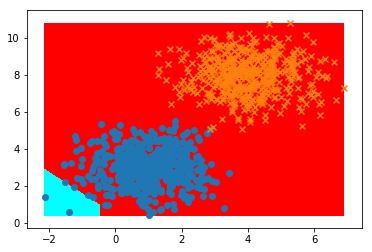

In [10]:
classifieur_random=ClassifierRandom(2)

# the_set=#TODO
plot_frontiere(the_set,classifieur_random)
plot2DSet(the_set)

### Étape 3 : k-NN

L'objectif est de définir le classifieur k-NN. Pour cela nous allons construire un tableau de distances que nous trierons grâce à la méthode `numpy.argsort`.

In [26]:
#nos données sont des points dans le plan
#pour chaque point, calcul dust euclidienne avec les autres -> table des distances
#recup k plus proches voisins en utilisant tab_dist
import math
class KNN(Classifier):
    def __init__(self, input_dimension, k):
        self.k = k #number of nearest neighbours
        self.input_dimension = input_dimension
        #Classifier.__init__(Classifier)
        #tableau des distances, une matrice

    def dist_euclidienne(self, x, y):
        res = math.sqrt(math.pow(x[0] - y[0], 2) + math.pow(x[1] - y[1], 2))
        return res
    
    def train(self, the_set):
        self.dataset = the_set
    
    def predict(self, x):
        tab_dist = []#tableau des distances
        #calcul dist x des points de mon dataset, contien [distance, label]
        for i in range(self.dataset.size()):
            tab_dist.append([self.dist_euclidienne(x, self.dataset.getX(i)), self.dataset.getY(i)[0]])
        
        #tri de dist selon la premiere case (distance)
        #np.argsort retourne les indices 
        nearest = np.argsort(tab_dist, 0)
        
        #compter nombre de labels "+1" dans les k premiers
        cpt = 0
        for i in range(self.k):
            index = nearest[i][0]#index de la i eme case la plus proche
            cpt += tab_dist[index][1] #label
            #print tab_dist[index]
            #print cpt
        if cpt > 0:
            return +1
        return -1
        
    def accuracy(self, dataset):
        #pour chaque x, y dans dataset comparer predict(x) et y
        #predict depend du modèle 
        cpt = 0;
        for i in range(dataset.size()):
            if self.predict(dataset.getX(i)) == dataset.getY(i):
                cpt+=1
        return float(cpt) / dataset.size()
    

In [89]:
def test(dataset, input_size, k):
    knn=KNN(input_size, k)
    knn.train(dataset)
    plot_frontiere(the_set,knn, 50)
    plot2DSet(dataset)
    print (knn.accuracy(dataset))

### Étape 4: protocole expérimental

Attention, lorsque vous testez un classifieur, il est nécessaire de considérer à la fois un ensemble d'apprentissage et un ensemble de test. La performance doit être évaluée sur l'ensemble de test (et non pas sur l'ensemble d'apprentissage).

0.999


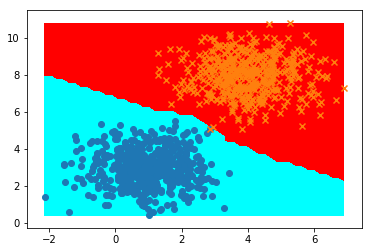

In [90]:
test(the_set, 2, 6)



#### Travail libre

Comparer la performance (en train et test) de plusieurs classifieurs KNN avec différentes valeurs de k. Que pouvez vous constater ?
Idéalement, vous tracerez la performance (accuracy) en fonction de la valeur de k.
Essayez avec différentes configurations de gaussiennes.

In [126]:
def test_knn(train_set, test_set, k):
    #test pour plusieures valeurs de k
    k_list = [x for x in range(1, k)]

    #liste des precisions pour test et train
    train_accuracy = []
    test_accuracy = []


    for k in k_list:
        knn = KNN(2, k)
        knn.train(train_set)

        test_accuracy.append(knn.accuracy(train_set)*100)
        train_accuracy.append(knn.accuracy(test_set)*100)
    #ajout legendes
    blue_patch = mpatches.Patch(color='blue', label='train')
    orange_patch = mpatches.Patch(color='orange', label='test')
    plt.legend(handles=[blue_patch, orange_patch])    
    
    plt.title('precision en fonction de la valeur de k')
    plt.xlabel('k')
    plt.ylabel('accuracy (%)')
    plt.plot(k_list, train_accuracy)#bleu
    plt.plot(k_list, test_accuracy)#orange

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: covariance is not positive-semidefinite.
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: covariance is not positive-semidefinite.
  """


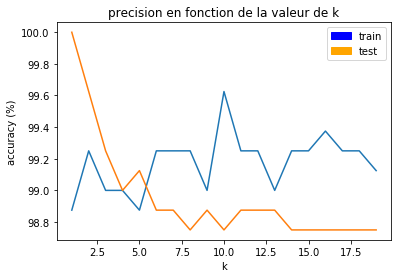

In [132]:
size = 400 #nombre de points

#generation de gaussiennes pour comparaison
test_gauss = np.random.multivariate_normal([1, 1], [[0.5, 1], [1, 0.5]], size)
train_gauss = np.random.multivariate_normal([1, 1], [[0.5, 1], [1, 0.5]], size)

test_gauss_bis = np.random.multivariate_normal([-2, -1.4], [[0.25, 0.1], [0.1, 0.25]], size)
train_gauss_bis = np.random.multivariate_normal([-2, -1.4], [[0.25, 0.1], [0.1, 0.25]], size)

test_dataset = LabeledSet(2)
train_dataset = LabeledSet(2)

#remplissage des dataset
for i in range(len(test_gauss)):
    #remplissage donnees test
    test_dataset.addExample(test_gauss[i], +1)
    test_dataset.addExample(test_gauss_bis[i], -1)
    #remplissage donnees train
    train_dataset.addExample(train_gauss[i], +1)
    train_dataset.addExample(train_gauss_bis[i], -1)

#test knn sur plusieures valeurs de k
test_knn(train_dataset, test_dataset, 20)

plus la valeur de k est grande plus la precision sur train est meilleure que celle sur test. On est dans le cas du surapprentissage.

### Étape 5 : données réelles UCI

Plusieurs datasets sont téléchargeables depuis: http://mldata.org

Voici la fonction permettant de les charger (en spécifiant leur nom). La fonction se charge de charger les données depuis le web.

In [133]:
from sklearn.datasets import fetch_mldata

def loadFile(name):
    data = fetch_mldata(name, data_home='.')
    print(data.data.shape)
    unique=np.unique(data.target)
    for i in range(len(data.target)):
        if (data.target[i]==unique[0]):
            data.target[i]=1
        else:
            data.target[i]=-1
    return data
data = loadFile('breast-cancer_scale')
#Les donnees sont dans data.data et data.target

(683, 10)


Écrire la fonction de split permettant de découper les données en un ensemble d'apprentissage et un ensemble de test.

In [134]:
def split(d):
    #contient les couples (data.data, data.target)
    data_list = [(d.data[i], d.target[i]) for i in range(len(d.data))]
    
    np.random.shuffle(data_list)
    
    list_1 = data_list[0:len(data_list)/2]
    list_2 = data_list[len(data_list)/2:]
    
    return list_1, list_2
    

Tester différents k-NN , pour différents k, et tracer la courbe de performance (accuracy) pour les données d'apprentissage et les données de test.

In [135]:
train_list, test_list = split(data)

In [136]:
#creation deux Labeledset: train_set et tes_set
#input_dimension : nombre de colonnes de data.data
train_set = LabeledSet(data.data.shape[1])
test_set = LabeledSet(data.data.shape[1])

#remplissant les Labeledsets
for t in train_list:
    train_set.addExample(t[0], t[1])
for t in test_list:
    test_set.addExample(t[0], t[1])

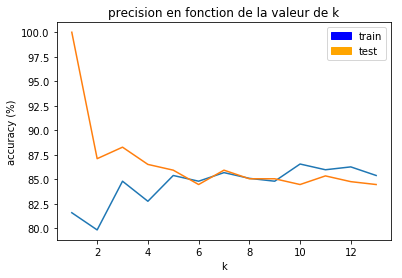

In [137]:
#test sur k entre 1 et 14
#train en bleu
#test en orange
test_knn(train_set, test_set, 14) 